In [1]:
from struct import unpack, calcsize
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

#params_pattern defines the structure we want to read in 
params_pattern = '=IBdddd' # (num_samples, sample_bytes, v_off, v_scale, h_off, h_scale, [samples]) ...
struct_size = calcsize(params_pattern)
#print(struct_size)

#Function to unpack the header
def unpackHeader(header):
    sHeader = unpack(params_pattern,header)
    numSamples=sHeader[0]
    bytesPerSample=sHeader[1]
    v_off=sHeader[2]
    v_scale=sHeader[3]
    h_off=sHeader[4]
    h_scale=sHeader[5]
    return numSamples,bytesPerSample,v_off,v_scale,h_off,h_scale

In [2]:
#Just some timing call for debugging
startTime = time.process_time()

#Now the main loop which is looping over both the cathode file and the anode file
with open("/home/svergani/oscilloscope/saved_outputs/2022_05_05/width100ns_0_100mV_ampScan.ch4.traces","rb") as fCat, open("/home/svergani/oscilloscope/saved_outputs/2022_05_05/width100ns_0_100mV_ampScan.ch3.traces","rb") as fAn:
    ampList=[]
    sigList=[]
    while True:
        #First read and unpack the headers
        header = fCat.read(struct_size)
        headerAn = fAn.read(struct_size)
        if not header: break
        numSamples,bytesPerSample,v_off,v_scale,h_off,h_scale=unpackHeader(header) 
        if not headerAn: break
        numSamplesAn,bpsAn,v_off_an,v_scale_an,h_off_an,h_scale_an=unpackHeader(headerAn)
        
        #Now read in the waveform samples
        dataType=np.dtype('>i1')
        dataList=np.fromfile(fCat,dataType,numSamples)
        anDataList=np.fromfile(fAn,dataType,numSamplesAn)

        #Convert to volts and seconds and subtract a baseline
        voltList=dataList*v_scale
        #voltList-=v_off
        baseline=np.mean(voltList[100:8000])
        voltList-=baseline
        voltListAn=anDataList*v_scale_an
        #voltListAn-=v_off_an
        baseline=np.mean(voltListAn[100:8000])
        voltListAn-=baseline
        ampList.append(-voltListAn) #for simplicity I turn the amp response up side down
        sigList.append(voltList)

    #Now convert the list of numpy array in to a fully feldged 2D array
    sigList=np.vstack(sigList)    
    ampList=np.vstack(ampList)

    #Make an array of time values (assumimg they are all the same sample rates in the file)
    sampList=np.arange(numSamples)
    timeList=sampList*h_scale
    timeList-=h_off
    timeList*=1e6 #Convert to microseconds
    
    #Finish time for optimisation purposes
    endTime = time.process_time()
    print("Process time was "+str(endTime-startTime))

Process time was 0.5275158689999997


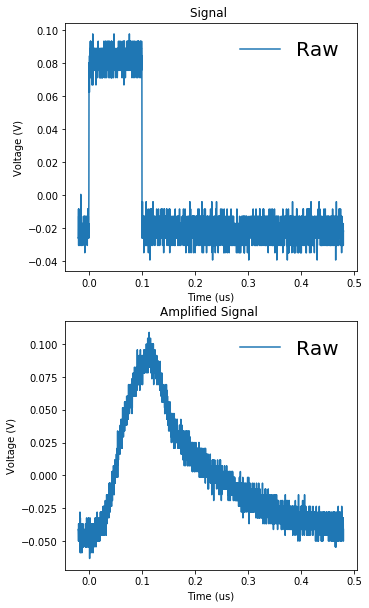

In [3]:
#Plot the raw waveforms
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList,sigList[0],label="Raw")
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title('Signal ')    
ax[0].legend(fontsize=20,loc='upper right')

ax[1].plot(timeList,ampList[0],label="Raw")
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title('Amplified Signal ')
ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

In [4]:
ampList_t = ampList.T
sigList_t = sigList.T

In [5]:
#averaging over all the waveforms
from statistics import mean

aveampList=[]
avesigList=[]

for i in range (ampList_t.shape[0]):
    aveampList.append(mean(ampList_t[i]))
    avesigList.append(mean(sigList_t[i]))
    

In [6]:
aveampList=np.array(aveampList)
avesigList=np.array(avesigList)

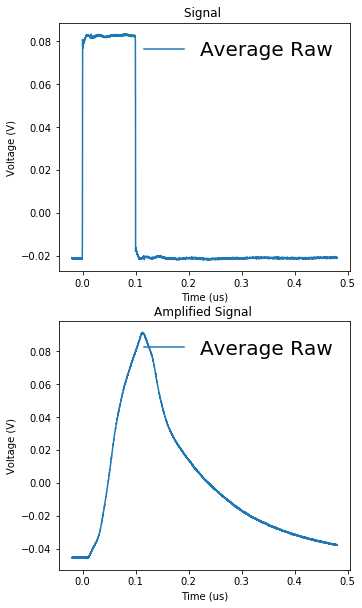

In [7]:
#Plot the raw waveforms
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList,avesigList,label="Average Raw")
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title('Signal ')    
ax[0].legend(fontsize=20,loc='upper right')

ax[1].plot(timeList,aveampList,label="Average Raw")
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title('Amplified Signal ')
ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

In [8]:
# Import curve fitting package from scipy
from scipy.optimize import curve_fit

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

#fitting both curves

pars, cov = curve_fit(f=gaussian, xdata=timeList, ydata=aveampList, p0=[0.09, 0.13, 0.1], bounds=(-np.inf, np.inf))

In [9]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals

In [10]:
print(pars)

[0.09012399 0.11496592 0.03286066]


In [11]:
print(stdevs)

[0.00121356 0.00051087 0.00051087]


In [12]:
res = aveampList - gaussian(timeList, *pars)

In [ ]:
# Plot the fit data as an overlay on the scatter data
#ax[0].plot(timeList, gaussian(timeList, *pars), linestyle='--', linewidth=2, color='black')

#Plot the raw waveforms
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList,aveampList,label="Average Raw")
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title('Amplified Signal ')    
a#fitting both curves

pars, cov = curve_fit(f=gaussian, xdata=timeList, ydata=aveampList, p0=[0.09, 0.13, 0.1], bounds=(-np.inf, np.inf))x[0].legend(fontsize=20,loc='upper right')

ax[1].plot(timeList,gaussian(timeList, *pars), linestyle='--', linewidth=2, color='black')
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title('Amplified Signal Fit')
ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

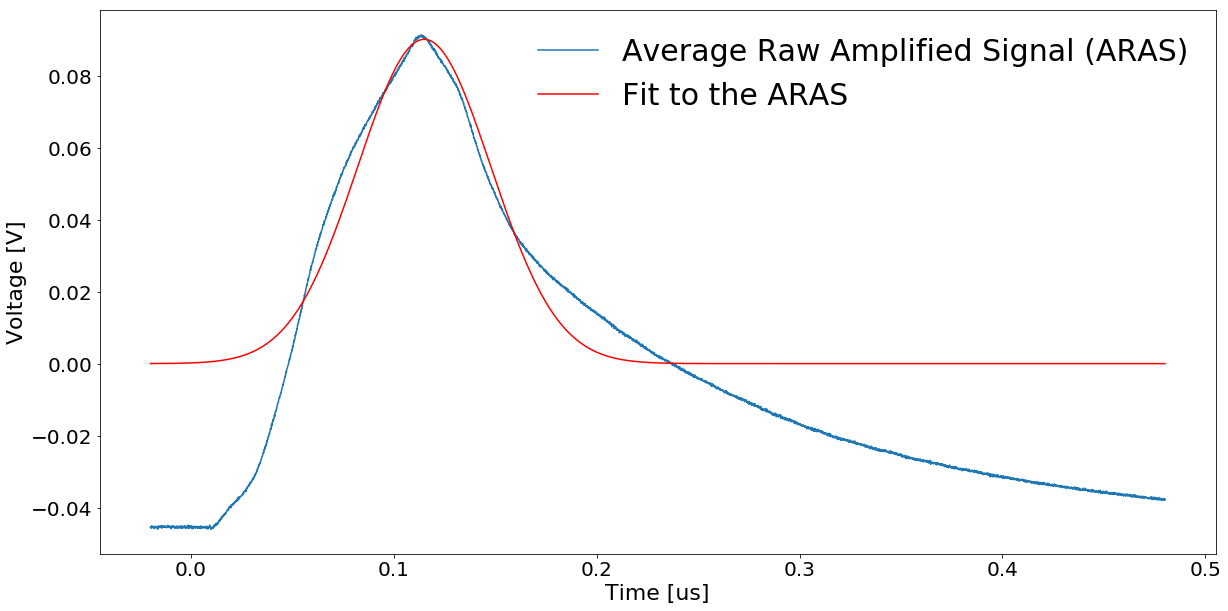

In [13]:
plt.figure(figsize=(20,10))
#plt.plot(x_plot,pion_plus_bis,'r',label='pion plus MC Integration')
#plt.plot(x_plot,pion_minus_bis,'-b',label='pion minus MC Integration')
plt.plot(timeList,aveampList,label="Average Raw Amplified Signal (ARAS)")
plt.plot(timeList,gaussian(timeList, *pars),color='red',label="Fit to the ARAS")
plt.legend(loc="upper right",prop={'size': 30})
plt.xlabel("Time [us]",fontsize=22)
plt.ylabel("Voltage [V]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [18]:
#fitting both curves

pars, cov = curve_fit(f=gaussian, xdata=timeList, ydata=aveampList, p0=[0,0,0], bounds=(-np.inf, np.inf))

/home/svergani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/svergani/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:

    
    #Now do some smoothing with a Savitzky-Golay filter (which is like a fancy running average)
    smoothCat=savgol_filter(cathodeList, 101, 3,axis=0) #Smooth window size 101 samples with a 3rd order polynomial
    #averageSamp11=savgol_filter(cathodeList, 11, 3,axis=0) #Smooth by sample number
    #averageSamp101=savgol_filter(cathodeList, 101, 3,axis=0) #Smooth by sample number
    smoothCat1=savgol_filter(cathodeList[0], 501, 3) # window size 51, polynomial order 3
    #smoothCat2=savgol_filter(cathodeList[1], 501, 3) # window size 51, polynomial order 3
    smoothAn=savgol_filter(anodeList[0], 101, 3) # window size 51, polynomial order 3
    
    #Plot the raw and smoothed waveforms
    fig, ax = plt.subplots(2,1)
    ax[0].plot(timeList,cathodeList[0],label="Raw")
    ax[0].plot(timeList,smoothCat[0],label="Savitzky-Golay Smoothed")
    ax[0].set_xlabel('Time (us)')
    ax[0].set_ylabel('Voltage (V)')
    ax[0].set_title('Cathode - vacuum/silver/30.60.120V ')    
    ax[0].legend(fontsize=20,loc='upper right')


    ax[1].plot(timeList,anodeList[0],label="Raw")
    ax[1].plot(timeList,smoothAn,label="Savitzky-Golay Smoothed")
    ax[1].set_xlabel('Time (us)')
    ax[1].set_ylabel('Voltage (V)')
    ax[1].set_title('Anode - vacuum/silver/30.60.120V ')
    ax[1].legend(fontsize=20,loc='upper right')
    plt.subplots_adjust(bottom=0.1, right=0.8, top=2)


In [ ]:
print(anodeList.shape)